<h1>DUNEX Data Exploration Notebook </h1>
Written By: EJ Rainville, Fall 2021

In [24]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy import signal
from scipy import fft
from scipy import interpolate
import cftime
import sys

# Import DUNEX Tools
sys.path.insert(1, '../tools/')
import microSWIFTTools
%matplotlib widget

<h2>Analysis of Mission 0</h2>

In [48]:
# Import data from mission netCDF
nc_file_name = '../microSWIFT_data/mission_0/mission_0.nc'
mission_0_dataset = nc.Dataset(nc_file_name, mode='r')
print(mission_0_dataset)
microSWIFTs_on_mission = list(mission_0_dataset.groups.keys())

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): single_value(1)
    variables(dimensions): float64 gps_freq(single_value), float64 imu_freq(single_value)
    groups: microSWIFT_25, microSWIFT_41, microSWIFT_31, microSWIFT_21, microSWIFT_11, microSWIFT_32


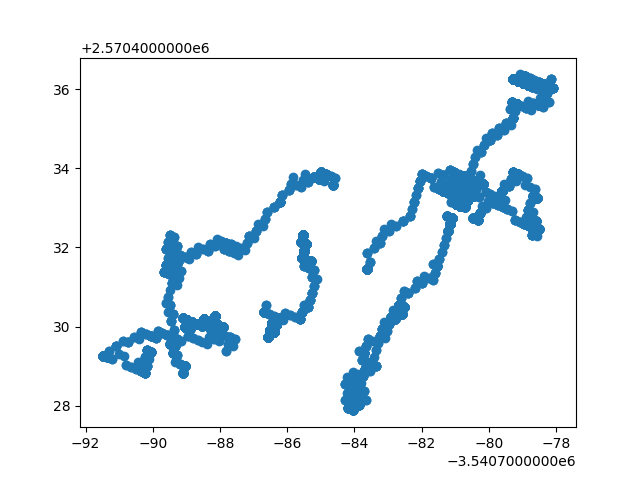

In [7]:
# Test FRF Coordinate Transform
x, y = microSWIFTTools.transform2FRF(lat=mission_0_dataset['microSWIFT_25']['GPS']['lat'][:], lon=mission_0_dataset['microSWIFT_25']['GPS']['lon'][:])

# Plot the transformed coordinates
fig, ax = plt.subplots()
ax.scatter(x,y)


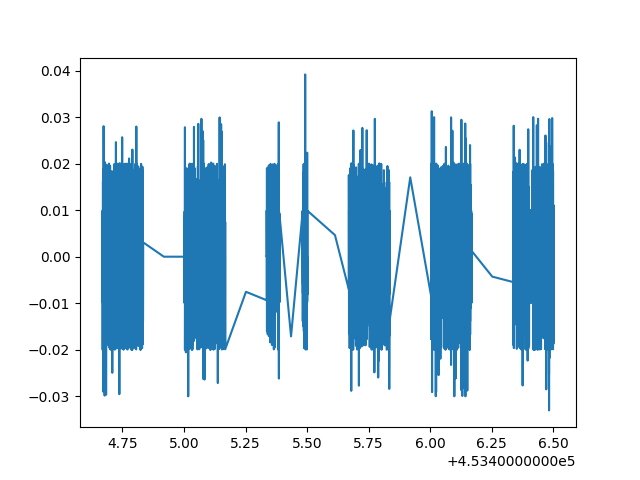

In [29]:
# Test new FRF coordinates from the missionNC build
# Plot the transformed coordinates
fig, ax = plt.subplots()
ax.plot(mission_0_dataset['microSWIFT_25']['GPS']['gps_vel_time'][:],mission_0_dataset['microSWIFT_25']['GPS']['u'][:])



In [45]:
# Compute actual sampling frequency for GPS and IMU 
gps_freq = 1 / (np.mean(np.diff(mission_0_dataset['microSWIFT_25']['GPS']['time'][0:10]) * 3600))
print(gps_freq)

imu_freq = 1 / (np.mean(np.diff(mission_0_dataset['microSWIFT_25']['IMU']['time'][0:1000]) * 3600))
print(imu_freq)

4.000000089406969
12.036144590738278
